In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Set a random seed for reproducibility
np.random.seed(42)

In [2]:
# Load your dataset from a SAS file
data_path = 'C:/Users/khtur/Desktop/Eas/Models/abt_app.sas7bdat'
df = pd.read_sas(data_path, encoding='LATIN2')

# Display the column names to verify the correct target column name
print("Column names in the dataset:\n", df.columns)


Column names in the dataset:
 Index(['cid', 'aid', 'product', 'period', 'act_age', 'act_cc', 'act_loaninc',
       'app_income', 'app_loan_amount', 'app_n_installments',
       ...
       'default3', 'default6', 'default9', 'default12', 'default_cross3',
       'default_cross6', 'default_cross9', 'default_cross12',
       'cross_app_loan_amount', 'cross_app_n_installments'],
      dtype='object', length=219)


In [3]:

# Separate features (X) and target (y)
# Replace 'default12' with the correct column name
X = df.drop(columns=['default12'])  # Features
y = df['default12']  # Target

# Handle missing values in the target
if y.isnull().sum() > 0:
    print(f"Missing values detected in the target: {y.isnull().sum()}")
    # Option 1: Fill missing values in the target with the most frequent value
    y.fillna(y.mode()[0], inplace=True)
    
    # Option 2: Drop rows where the target is missing
    # X = X[y.notnull()]
    # y = y.dropna()

# Function to convert categorical/object and bool columns to numeric
def convert_to_numeric(df):
    for column in df.select_dtypes(include=['object']).columns:
        if df[column].nunique() <= 2:
            # Use Label Encoding for binary object columns
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
        else:
            # Use One-Hot Encoding for categorical columns with more than 2 values
            df = pd.get_dummies(df, columns=[column], drop_first=True)
    return df

# Ensure X is fully numeric (including converting bool columns)
X = convert_to_numeric(X)

# Identify and convert all bool columns to int (0 and 1)
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Fill missing numeric values in the features with the median
X.fillna(X.median(), inplace=True)

# Ensure X and y are ready for modeling
print("Missing values in features after handling:\n", X.isnull().sum().sum())  # Should be 0 if no missing values
print(f"Data types in X: \n{X.dtypes}")  # Check that all columns are numeric



Missing values detected in the target: 1576
Missing values in features after handling:
 0
Data types in X: 
product                         int32
act_age                       float64
act_cc                        float64
act_loaninc                   float64
app_income                    float64
                               ...   
cross_aid_css1988050500077      int32
cross_aid_css1988051500007      int32
cross_aid_css1988051500132      int32
cross_aid_css1988051600110      int32
cross_aid_css1988051800039      int32
Length: 18909, dtype: object



Starting Run 1/1
Data split completed for Run 1
32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/15 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5942857142857143	BernoulliNB(input_matrix, BernoulliNB__alpha=0.01, BernoulliNB__fit_prior=True)

Generation 2 - Current Pareto front scores:

-1	0.6257142857142857	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.25, ExtraTreesClassifier__min_samples_leaf=9, ExtraTreesClassifier__min_samples_split=13, ExtraTreesClassifier__n_estimators=100)
TPOT run 1 completed.
Best pipeline obtained for Run 1: Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(criterion='entropy', max_features=0.25,
                                      min_samples_leaf=9,
                                      min_samples_split=13))])
AUC for Run 1: 0.6799


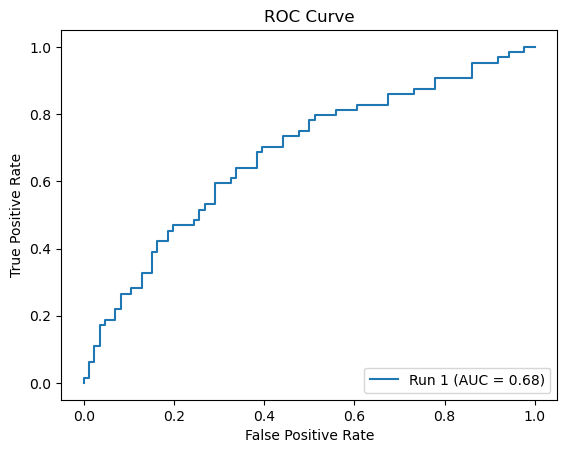

Top 10 Feature importances for Run 1:
                   Feature  Importance
15         act_ccss_n_loan    0.200170
16         act_call_n_loan    0.140283
7   app_number_of_children    0.135204
14         act_cins_n_loan    0.087103
18  act_cins_min_seniority    0.072149
13             act_call_cc    0.054326
2                   act_cc    0.052181
17      act_cins_seniority    0.044614
19   act_cins_n_loans_hist    0.042564
12           app_char_cars    0.036721

Top 20 important features across all runs:
       feature  importance
7   feature_15    0.200170
8   feature_16    0.140283
17   feature_7    0.135204
6   feature_14    0.087103
10  feature_18    0.072149
5   feature_13    0.054326
12   feature_2    0.052181
9   feature_17    0.044614
11  feature_19    0.042564
4   feature_12    0.036721
13   feature_3    0.033493
1    feature_1    0.030719
3   feature_11    0.029283
14   feature_4    0.020998
18   feature_8    0.020194
16   feature_6    0.000000
0    feature_0    0.000000
15 

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming your full dataset (X and y) is already loaded and cleaned
# Example: X, y = load_dataset_function()  # Use your actual loading function

# For a quick test, we'll sample the data and limit the number of features
X_sample = X.sample(n=500, random_state=42)  # Use only 500 samples for quick testing
y_sample = y.loc[X_sample.index]  # Match the sampled X with corresponding y values

# Limit the features to a manageable size for fast testing
X_sample = X_sample.iloc[:, :20]  # Use only the first 20 features

# Set TPOT parameters for a quick run
n_runs = 1  # Reduce the number of TPOT runs to 1
generations = 2  # Use only 2 generations for fast feedback
population_size = 5  # Use a small population size for faster optimization
cv = 2  # Reduce cross-validation to 2-fold for quicker testing

all_tpot_models = []
all_feature_importances = []

for i in range(n_runs):
    print(f"\nStarting Run {i+1}/{n_runs}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)
    print(f"Data split completed for Run {i+1}")
    
    # Run TPOT
    tpot = TPOTClassifier(generations=generations, population_size=population_size, cv=cv, n_jobs=-1, verbosity=3)
    tpot.fit(X_train, y_train)
    print(f"TPOT run {i+1} completed.")
    
    # Store the TPOT model
    all_tpot_models.append(tpot)
    
    # Get the best pipeline
    best_pipeline = tpot.fitted_pipeline_
    print(f"Best pipeline obtained for Run {i+1}: {best_pipeline}")
    
    # Compute AUC for the test set
    try:
        y_test_pred_prob = best_pipeline.predict_proba(X_test)[:, 1]  # Get predicted probabilities
        auc_score = roc_auc_score(y_test, y_test_pred_prob)
        print(f"AUC for Run {i+1}: {auc_score:.4f}")
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
        plt.plot(fpr, tpr, label=f'Run {i+1} (AUC = {auc_score:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    except Exception as e:
        print(f"Error calculating AUC for Run {i+1}: {e}")
    
    # Collect feature importance (if available)
    try:
        # Extract the final estimator
        final_estimator = best_pipeline.steps[-1][1]
        
        # Transform the data through the pipeline (up to the final estimator)
        if len(best_pipeline.steps) > 1:
            X_train_transformed = best_pipeline[:-1].transform(X_train)
        else:
            X_train_transformed = X_train

        # If the model has feature_importances_ or coef_, extract them
        if hasattr(final_estimator, 'feature_importances_'):
            importances = final_estimator.feature_importances_
        elif hasattr(final_estimator, 'coef_'):
            importances = final_estimator.coef_[0]
        else:
            # Use permutation importance if the model doesn't have built-in feature importance
            print(f"Using Permutation Importance as model doesn't have feature_importances_ or coef_.")
            result = permutation_importance(final_estimator, X_train_transformed, y_train, n_repeats=2, random_state=42)
            importances = result.importances_mean
        
        # Append the feature importances to the list
        all_feature_importances.append(importances)
        
        # Manually map original feature names if the transformation is simple
        if X_train_transformed.shape[1] == X_train.shape[1]:
            transformed_features = X_train.columns  # Use original feature names
        else:
            # If feature count doesn't match, fallback to generic feature names
            transformed_features = [f"feature_{i}" for i in range(len(importances))]
        
        # Create a DataFrame for the feature importances
        feature_importances = pd.DataFrame({
            'Feature': transformed_features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(10)
        
        # Display top 10 feature importances
        print(f"Top 10 Feature importances for Run {i+1}:")
        print(feature_importances)
        
    except Exception as e:
        print(f"Error extracting feature importances for Run {i+1}: {e}")

# Continue to aggregate and analyze the collected feature importances
import numpy as np
import pandas as pd

# Collect and compare feature importances from all runs
importance_df_list = []

for i, importances in enumerate(all_feature_importances):
    # Check if feature names match importances length
    if len(importances) == len(X.columns):
        feature_names_to_use = X.columns  # Use original feature names if lengths match
    else:
        # If the number of features has changed, use generic names for reduced features
        feature_names_to_use = [f"feature_{i}" for i in range(len(importances))]
    
    importance_df = pd.DataFrame({
        'feature': feature_names_to_use,
        'importance': np.abs(importances),
        'run': f'Run {i+1}'
    }).sort_values(by='importance', ascending=False)
    
    importance_df_list.append(importance_df)

# Concatenate all importance dataframes for comparison
all_importances_df = pd.concat(importance_df_list)

# Calculate mean importance across runs for comparison
mean_importance_df = all_importances_df.groupby('feature')['importance'].mean().reset_index()
mean_importance_df = mean_importance_df.sort_values(by='importance', ascending=False)

# Display the top 20 important features
print("\nTop 20 important features across all runs:")
print(mean_importance_df.head(20))
